In [4]:
import torch
from torch import nn

import torch.functional as F
import torchvision.transforms.functional as TF
import torch.utils.checkpoint as checkpoint

import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

import numpy as np
import random

import sys
sys.path.append("../includes")

import models
import utils

import imageio
import imageio_ffmpeg

use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")

# Load images

1f41e
1f98b


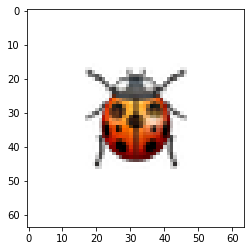

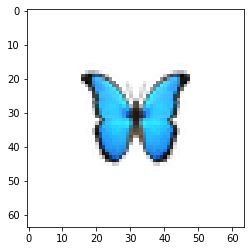

In [5]:
image_1 = utils.load_emoji("🐞", 32, 16).to(device)
image_2 = utils.load_emoji("🦋", 32, 16).to(device)

plt.imshow(image_1.transpose(0, 2).cpu())
plt.show()
plt.imshow(image_2.transpose(0, 2).cpu())
plt.show()

img_size = 64

# Set up model and pool

## Hyperparameters

In [8]:
n_channels = 16
n_epochs = 10000
lr = 0.001
pool_size = 1024
batch_size = 16
hidden_size = 64

model = models.Automata((64, 64), n_channels, hidden_size, device).to(device)

## Initialize pool

In [9]:
images = torch.stack([image_1, image_2])

# initialize pool with seeds
seed = torch.zeros(n_channels, img_size, img_size).to(device)
seed[3:, 32, 32] = 1

seed_1 = seed.clone()
seed_2 = seed.clone()

seed_1[4, 32, 32] = 0

seeds = torch.stack([seed_1, seed_2])

pool_initials = seeds.repeat(pool_size//2, 1, 1, 1)
pool_targets = images.repeat(pool_size//2, 1, 1, 1)

pool_target_ids = torch.Tensor([0, 1]).repeat(pool_size//2).long()
# 0 for image_1, 1 for image_2
# half image 1, half image 2

# Train model

In [10]:
losses = []

criterion = nn.MSELoss(reduction='none')
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

for i in range(n_epochs):

    iterations = random.randint(96, 128)

    pool_indices = torch.Tensor(random.sample(
        range(pool_size), batch_size)).long()

    initial_states = pool_initials[pool_indices]
    targets = pool_targets[pool_indices]
    target_ids = pool_target_ids[pool_indices]

    out = model(initial_states, iterations)

    phenotypes = out[:, :4].squeeze()

    optimizer.zero_grad()

    loss = criterion(phenotypes, targets)

    per_sample_loss = loss.mean((1, 2, 3))
    total_loss = per_sample_loss.mean()

    total_loss.backward()
    optimizer.step()

    # argsort the losses per sample
    ranked_loss = per_sample_loss.argsort()

    # get indices of min- and max-loss samples
    min_loss_indices = ranked_loss[:1]
    max_loss_indices = ranked_loss[1:]

    replacements = out.detach()

    max_loss_targets = target_ids[max_loss_indices]

    # high-loss outputs are re-tasked with
    # mapping the seeds to the respective image

    # low-loss outputs are tasked with mapping
    # the previous output to the same image

    replacements[max_loss_indices] = seeds[max_loss_targets]
    pool_initials[pool_indices] = replacements

    if i % 100 == 0:

        print(i, np.log10(float(total_loss.cpu().detach())))

        torch.save(model.state_dict(), "../models/divergence_"+str(i))

    losses.append(float(total_loss))

0 -1.319054357188048
100 -1.6611118261533007
200 -1.6714660586068448
300 -1.8655350979544634
400 -2.1736268819408915
500 -2.1439353454818852
600 -2.1610145888425443
700 -2.314789385689941
800 -2.2770731153573602
900 -2.3258022341800704
1000 -2.412023401376395
1100 -2.399226837708955
1200 -2.1888243728656214
1300 -2.339243649753174
1400 -2.5164395161962467
1500 -2.4726936077887203
1600 -2.4967426381558284
1700 -2.4563035185659436
1800 -2.494958146570903
1900 -2.514441446337691
2000 -2.5060750530948295
2100 -2.4965245956255284
2200 -2.5955618922115913
2300 -2.6377119316372593
2400 -2.4513168951118183
2500 -2.629245375597889
2600 -2.639665758685506
2700 -2.6928639789709994
2800 -2.6333271256191155
2900 -2.7262018308499623
3000 -2.7265491208603763
3100 -2.4725280081012317
3200 -2.6797931276403926
3300 -2.7181376575531693
3400 -2.6694939559551054
3500 -2.6130356622526105
3600 -2.723481177541114
3700 -2.7781627066936014
3800 -2.6785953322016107
3900 -2.796332288603701
4000 -2.839740159596476

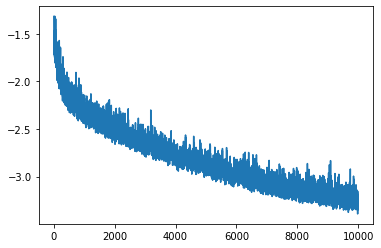

In [12]:
plt.plot(np.log10(losses))

# Load model checkpoint

In [ ]:
model.load_state_dict(torch.load(
    "../models/divergence_10000", map_location=torch.device('cpu')))

In [ ]:
seed_mix = seed.clone()
seed_mix[4, 32, 32] = 0.5

In [ ]:
video = utils.get_model_history(model, seed_1, 128)
utils.channels_to_gif("../videos/divergence_seed_1_channels.gif", video)
utils.colors_to_gif("../videos/divergence_seed_1_colors.gif", video)

video = utils.get_model_history(model, seed_2, 128)
utils.channels_to_gif("../videos/divergence_seed_2_channels.gif", video)
utils.colors_to_gif("../videos/divergence_seed_2_colors.gif", video)

video = utils.get_model_history(model, seed_mix, 128)
utils.channels_to_gif("../videos/divergence_seed_mix_channels.gif", video)
utils.colors_to_gif("../videos/divergence_seed_mix_colors.gif", video)